In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/cybersecurity'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [36]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


 frog  bird   dog  ship


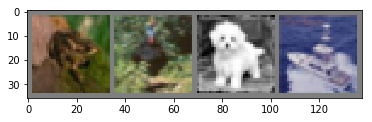

In [8]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [10]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 4 # pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_train_loader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(16 * 5 * 5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        

    def forward(self, x):
      x =self.pool(F.relu(self.conv1(x)))
      x =self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
        
      return x

In [49]:
# initalize a target model and train it

target_model = Net()
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss
optimizer = optim.Adam(target_model.parameters(), lr=0.001)# try Adam VS SGD

# let the magic begin
for epoch in range(0,4):  

    running_loss = 0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = target_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # make a prediction: forward prop
        running_loss += loss.item()
        # calculate the loss
        
        # calculate gradients
    running_loss /= len(trainloader)  
        # updaate weights in backprop
    # train_accuracy = calculate_accuracy(trainloader, )
    # test_accuracy = calculate_accuracy(testloader, )
        # print statistics
    print("Iteration: {0} | Loss: {1} ".format(epoch, running_loss))    
       
        
        

print('Finished Training the Target model...')

Iteration: 0 | Loss: 0.45196832684040067 
Iteration: 1 | Loss: 0.3815596821188927 
Iteration: 2 | Loss: 0.3483480687260628 
Iteration: 3 | Loss: 0.3236499728536606 
Finished Training the Target model...


In [50]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        images, labels = data
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %




---



In [51]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss
shadow_optimizer = optim.Adam(shadow_model.parameters(), lr=0.001)# try Adam VS SGD

# let the magic begin
for epoch in range(0,4):  

    running_loss = 0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        shadow_optimizer.zero_grad()
        # forward + backward + optimize
        outputs = shadow_model(inputs)
        loss = shadow_criterion(outputs, labels)
        loss.backward()
        shadow_optimizer.step()
        # make a prediction: forward prop
        running_loss += loss.item()
        # calculate the loss
        
        # calculate gradients
    running_loss /= len(trainloader)  
        # updaate weights in backprop
    # train_accuracy = calculate_accuracy(trainloader, )
    # test_accuracy = calculate_accuracy(testloader, )
        # print statistics
    print("Iteration: {0} | Loss: {1} ".format(epoch, running_loss))    
       
        
print('Finished Training the Shadow model')

Iteration: 0 | Loss: 0.4471665799999237 
Iteration: 1 | Loss: 0.3787876875782013 
Iteration: 2 | Loss: 0.3522720815896988 
Iteration: 3 | Loss: 0.3288493037366867 
Finished Training the Shadow model


In [52]:
# freeze the Shadow model 
# make predictions on both datasets (shadow_in and shdow_out)
correct = 0
total = 0

with torch.no_grad():
    for data in shadow_out_loader:
        images, labels = data
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together


Accuracy of the network on the 10000 test images: 49 %


In [0]:
# create the Attack Model: A NN binary classifier {0, 1}
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1


In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?